## Imports

In [1]:
import copy
import numpy as np
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem description

Problem:

$$y = x_1 + x_2 + 100 +\epsilon$$

where $\epsilon \sim N(0,0.01)$. 


Can make $x_3$ dependent on $x_1$. The depedence is defined in the following way:

\begin{align*}
 x_1 &\sim Unif(-10,10) \\
 x_3 &\sim Unif(-10,10) \\
 x_3 &= \text{dep}\cdot x_1 + (1-\text{dep})\cdot x_3
\end{align*}

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
n_samples = config['n_samples']
lr = config['lr']
class_problem = config["class_problem"]
non_lin = config["non_lin"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




# Define BATCH sizes
BATCH_SIZE = int((n_samples*0.8)/100)
TEST_BATCH_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n_samples*0.80)/100)
TEST_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

print(NUM_BATCHES)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

1.0


# ReLU based network

## Seperate a test set for later

In [3]:
# Get linear data
y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=class_problem)

n, p = X.shape  # need this to get p 
print(n,p,dim)

# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

40000 4 50


In [4]:
test_dat[20]

tensor([-1.2466,  7.4463,  5.1044, -1.7821,  1.0000])

In [5]:
X_test[20]

array([-1.24657859,  7.44630309,  5.1044135 , -1.78210693])

In [6]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu_lime_comp", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

network 0
254
0
loss 1736.89990234375
nll 487.3662109375
density 0.6514045741541061

val_loss: 1430.6436, val_nll: 188.4482, val_ensemble: 0.9888, used_weights_median: 144

1
loss 700.18994140625
nll 141.3323211669922
density 0.29366877830337995

val_loss: 663.3726, val_nll: 106.7126, val_ensemble: 0.9900, used_weights_median: 41

2
loss 334.9444274902344
nll 0.9992531538009644
density 0.18333890958043828

val_loss: 381.8651, val_nll: 52.1754, val_ensemble: 0.9945, used_weights_median: 16

3
loss 222.4160614013672
nll 1.1725878715515137
density 0.12124746799007

val_loss: 319.1636, val_nll: 101.3643, val_ensemble: 0.9925, used_weights_median: 8

4
loss 194.06411743164062
nll 11.281781196594238
density 0.10303607472290989

val_loss: 276.3846, val_nll: 93.0687, val_ensemble: 0.9928, used_weights_median: 8

5
loss 154.01177978515625
nll 3.4408867359161377
density 0.07923078904205458

val_loss: 205.4568, val_nll: 53.9428, val_ensemble: 0.9945, used_weights_median: 8

6
loss 138.91810607910

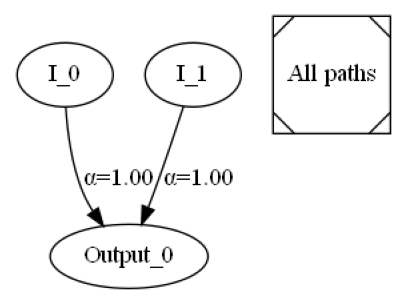

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_relu_lime_comp.png")
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 2 weights used in median model $\rightarrow$ density of 0.79% compared to initialized model (254 inital weigths) 
* ACC of 99\% for median model
* ACC of 99\% for full model

## Weight graph

In [8]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu_lime_comp", show=False)

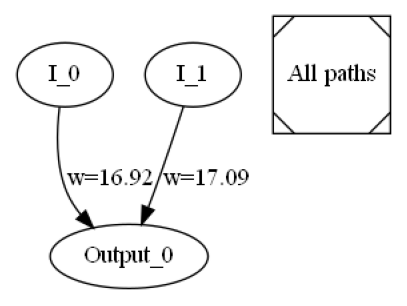

In [9]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu_lime_comp.png")
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### Lime code

In [10]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 2))
    else:
        preds = np.zeros((1000, len(x), 2))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 1] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=["x0", "x1", "x2", "x3"], class_names=["Class 0", "Class 1"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=4,  # Number of features to include in the explanation
        num_samples=10_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=["x0", "x1", "x2", "x3"]):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.grid()
    plt.show()

### SHAP code

In [11]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=100_000, batch_size=1000)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = ["x0", "x1", "x2", "x3"]):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.grid()
    plt.show()

In [12]:
variable_names=["x0", "x1", "x2", "x3"]

### Positiv prediction

In [13]:
for i in range(100):
    print(i)
    print(test_dat[i,:-1].reshape(-1, p))

0
tensor([[ 5.1286, -1.6452, -5.5493, -6.3167]])
1
tensor([[ 0.3956,  6.1388,  8.3702, -1.2827]])
2
tensor([[-5.0318, -1.2427, -5.9460,  9.8970]])
3
tensor([[ 8.5794, -7.7296,  0.9721, -4.3194]])
4
tensor([[-3.6403, -8.5835, -2.1992,  0.7718]])
5
tensor([[-8.4184,  1.1776,  3.5302, -4.7641]])
6
tensor([[-6.0205,  8.3711, -1.8137,  5.8843]])
7
tensor([[-5.4101,  6.5642,  0.1030,  9.4308]])
8
tensor([[ 9.7469,  2.2236,  2.0970, -4.1893]])
9
tensor([[-4.1268,  7.9073, -3.6176,  1.7491]])
10
tensor([[ 0.0116, -9.8697, -6.5752, -8.0694]])
11
tensor([[-7.0729,  3.1408, -4.2776,  1.2152]])
12
tensor([[ 3.5548, -3.5048,  9.5702,  3.8180]])
13
tensor([[-9.1692, -3.5567, -3.8946,  7.0207]])
14
tensor([[-5.0345,  6.9989,  1.9700, -9.2396]])
15
tensor([[ 2.9446,  9.3088, -5.5770, -6.1268]])
16
tensor([[-8.2873,  6.7787, -4.3606, -2.6229]])
17
tensor([[-7.5460,  4.6490,  7.3805,  3.1919]])
18
tensor([[ 1.3774, -0.9081,  0.8379, -6.5981]])
19
tensor([[ 5.7414, -8.3068,  7.3921,  0.0754]])
20
tensor(

In [15]:
expl

array([[16.727388, 17.168022,  0.      ,  0.      ],
       [17.044193, 17.184967,  0.      ,  0.      ],
       [17.035662, 16.915092,  0.      ,  0.      ],
       ...,
       [16.90043 , 17.175621,  0.      ,  0.      ],
       [17.034472, 17.167456,  0.      ,  0.      ],
       [17.046848, 17.105457,  0.      ,  0.      ]], dtype=float32)

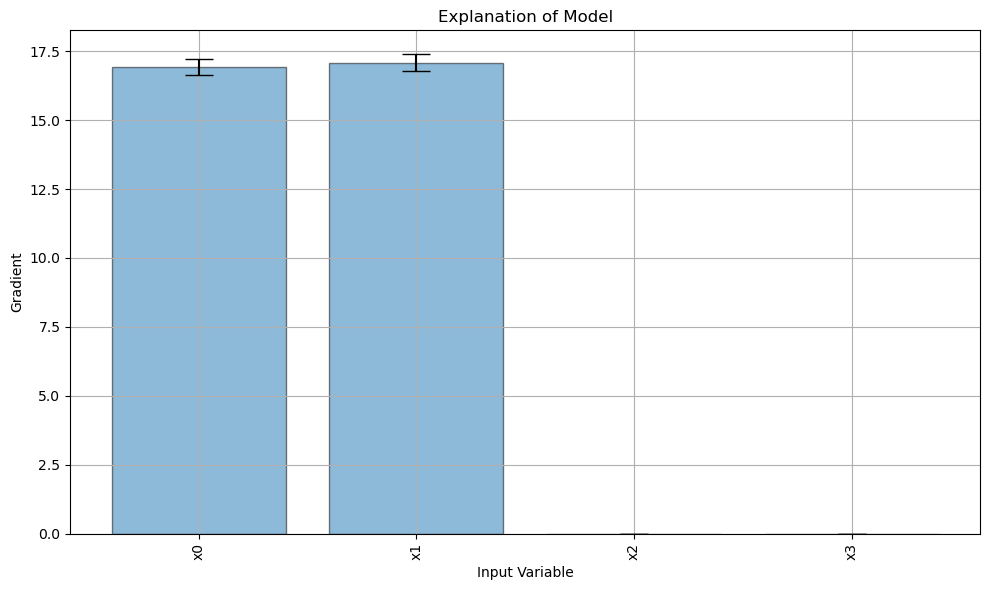

In [21]:
i = 1
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]


# remove variables that does not contribute to the prediction at all
expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 6))
plt.bar(range(p), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

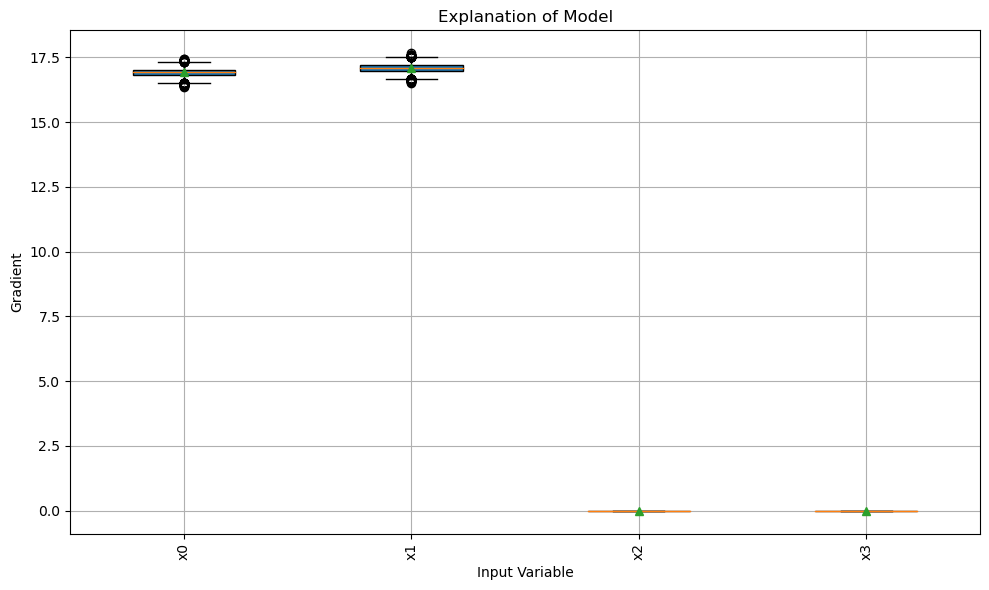

In [22]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(expl, vert=True, patch_artist=True, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, p + 1), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

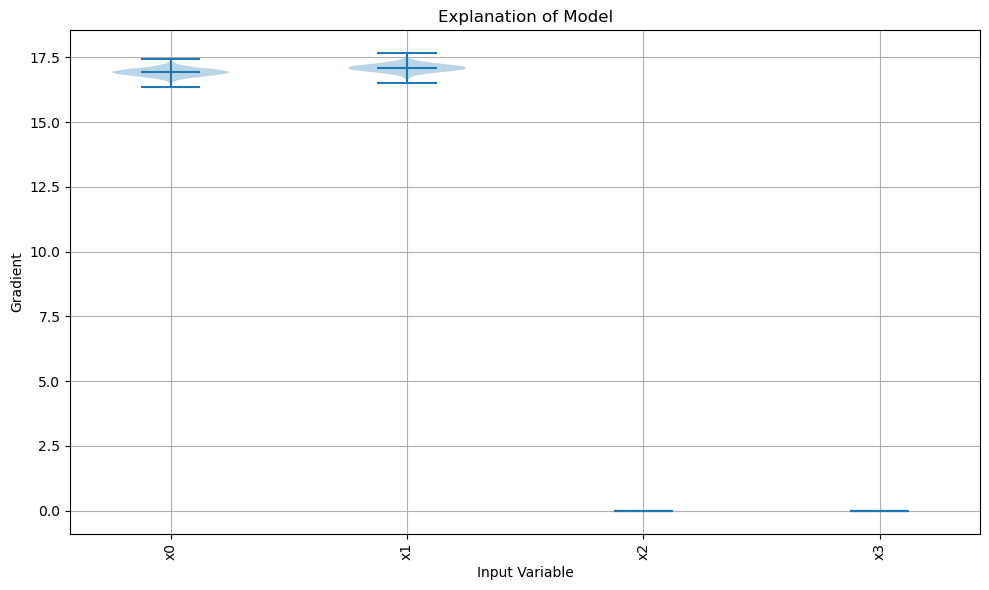

In [23]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.violinplot(expl, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, len(variable_names) + 1), variable_names, rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

#### Empirical approach

In [ ]:
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
from importlib import reload
reload(pf)
reload(pip_func)

os.chdir(current_dir) # set the working directory back to this one 


True class: 1.0


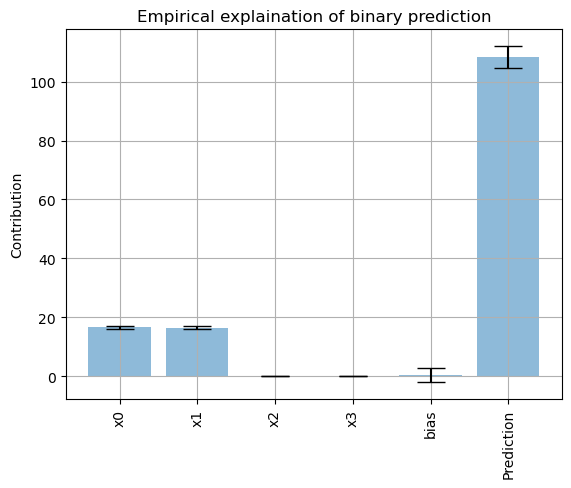

In [17]:
i = 1
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=True)

True class: 1.0


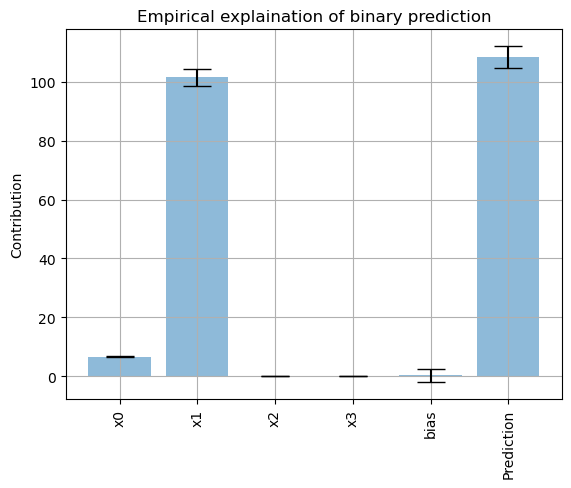

In [18]:
i = 1
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=False)

#### Lime explanation

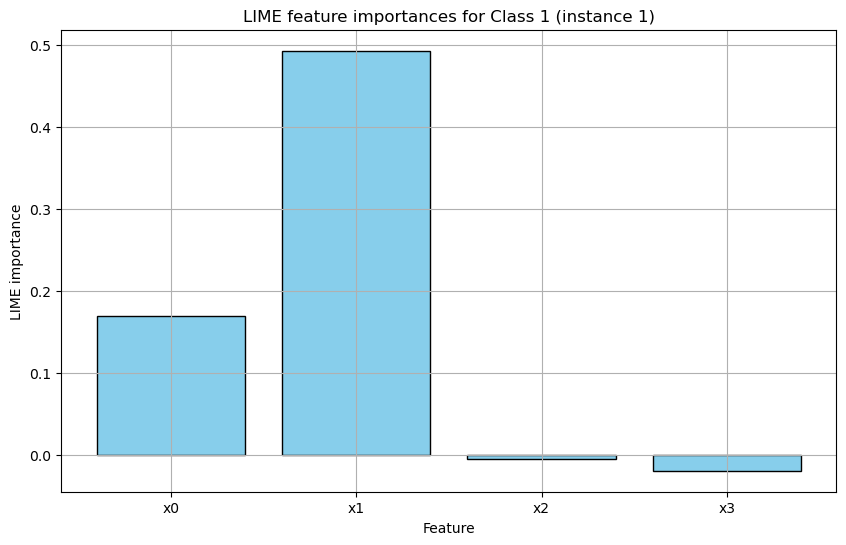

In [19]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [20]:
exp.local_exp

{1: [(1, 0.49252279329877846),
  (0, 0.16893888228506512),
  (3, -0.019419790089323468),
  (2, -0.005029572909583823)]}

In [21]:
exp.local_pred

array([0.97343415])

#### Shap explanation

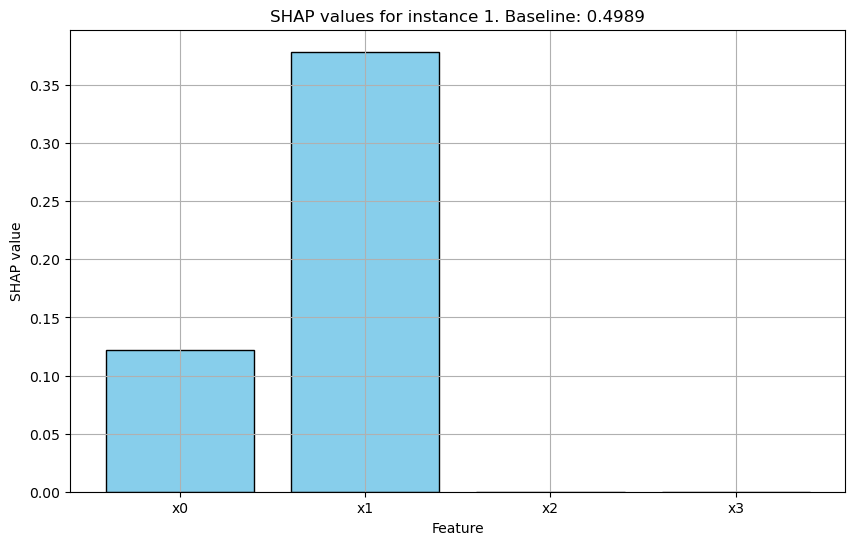

In [22]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

### Negative prediction

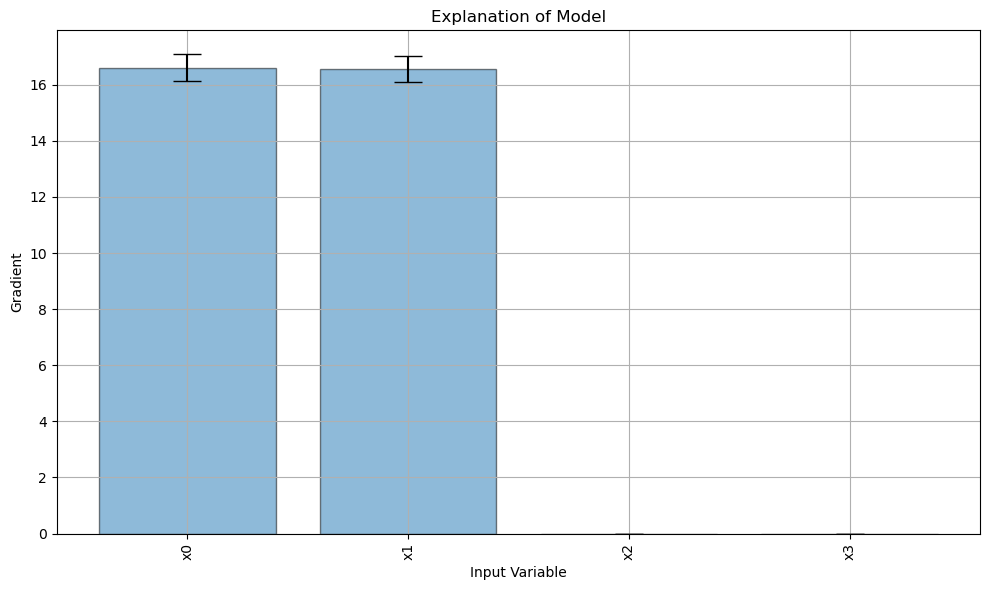

In [37]:
i = 2
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]


# remove variables that does not contribute to the prediction at all
expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 6))
plt.bar(range(p), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

#### Empirical approach

True class: 0.0


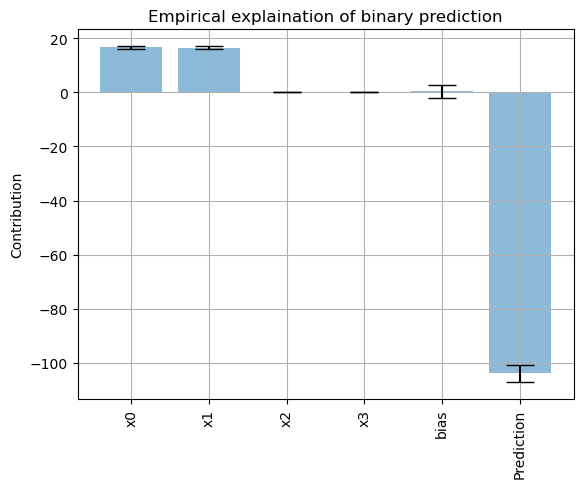

In [23]:
i = 2
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=True)

True class: 0.0


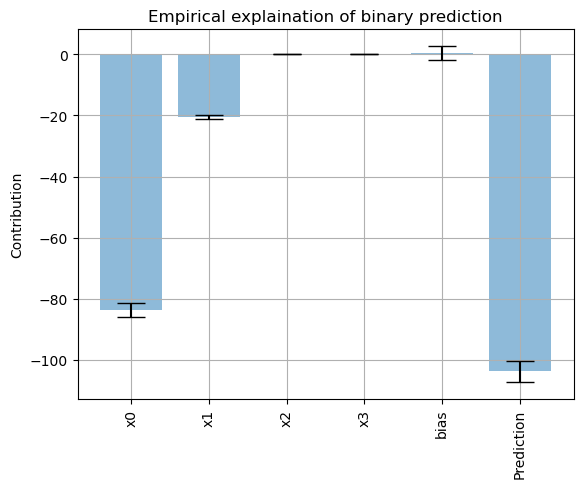

In [24]:
i = 2
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=False)

#### LIME explanation

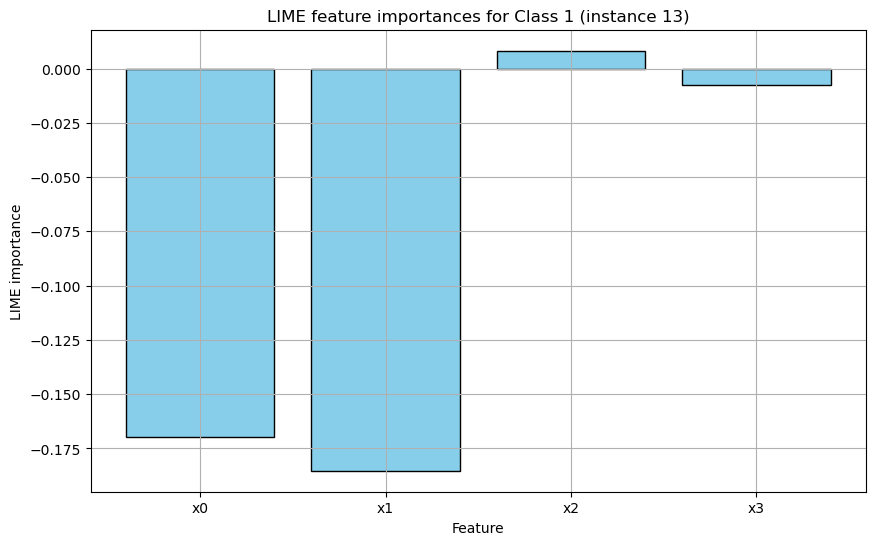

In [39]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [40]:
exp.local_exp

{1: [(1, -0.18527973604878462),
  (0, -0.16982051513992305),
  (2, 0.008193062443603833),
  (3, -0.007520260239444592)]}

#### SHAP explanation

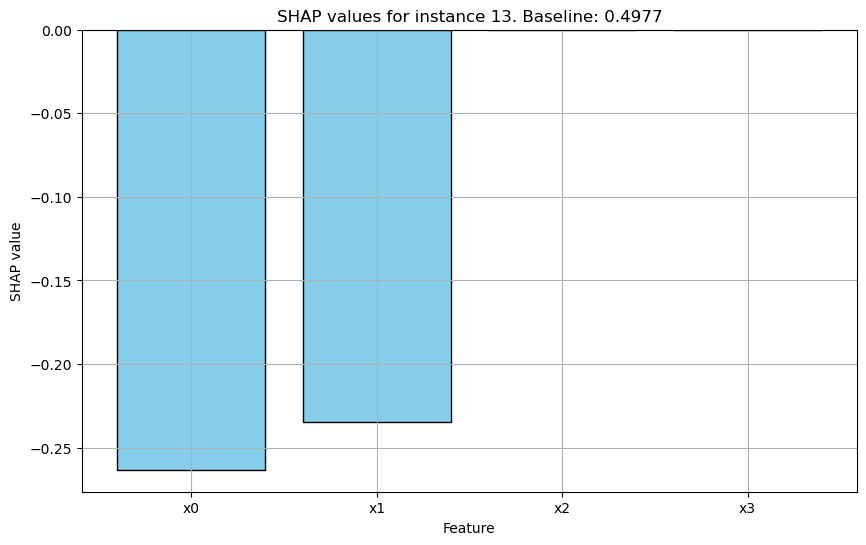

In [41]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [42]:
shap_vals

.values =
array([[-0.26321167, -0.23452426,  0.        ,  0.        ]])

.base_values =
array([[0.497736]])

.data =
array([[-0.81583332, -0.17766194, -8.4510449 ,  8.34451649]])

### Uncertain prediction

#### Empirical explanation

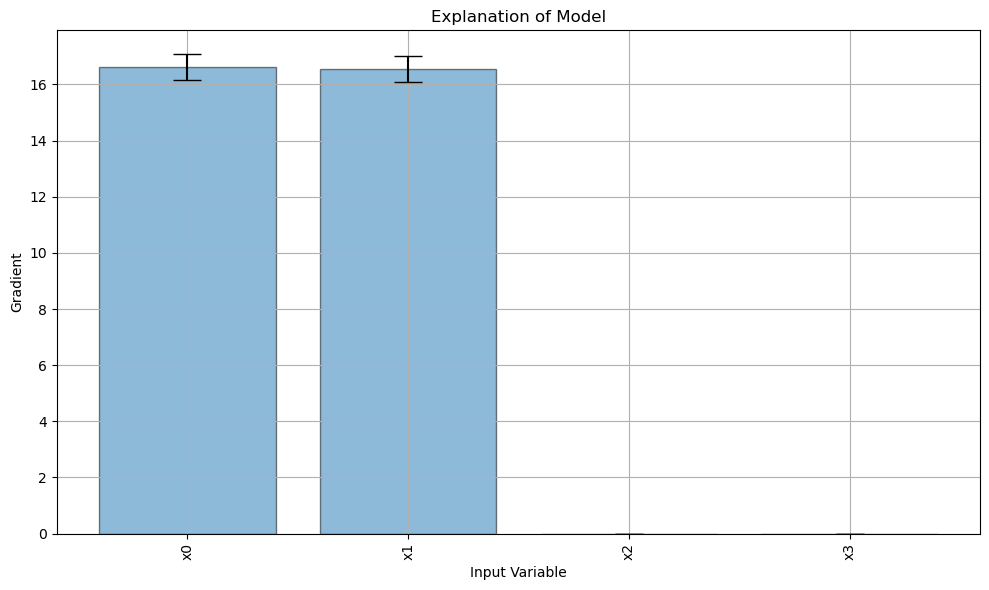

In [38]:
i = 12
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]


# remove variables that does not contribute to the prediction at all
expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 6))
plt.bar(range(p), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

In [31]:
for i in range(100):
    if abs(test_dat[i,:-1].reshape(-1, p)[0,0] + test_dat[i,:-1].reshape(-1, p)[0,1]) < 0.1:
        print(i)
        print(test_dat[i,:-1].reshape(-1, p))

12
tensor([[ 3.5548, -3.5048,  9.5702,  3.8180]])


True class: 1.0


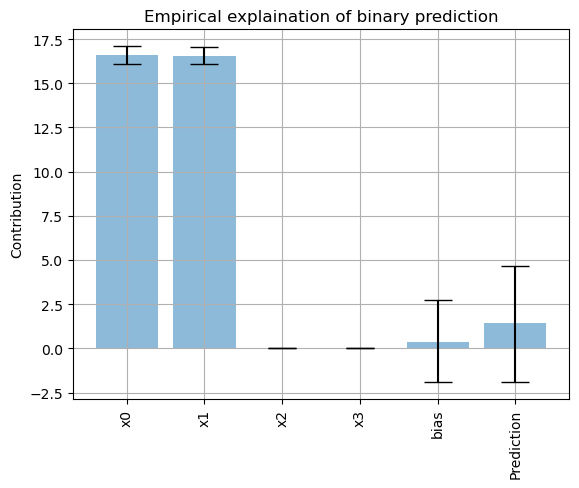

In [32]:
i = 12
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=True)

True class: 1.0


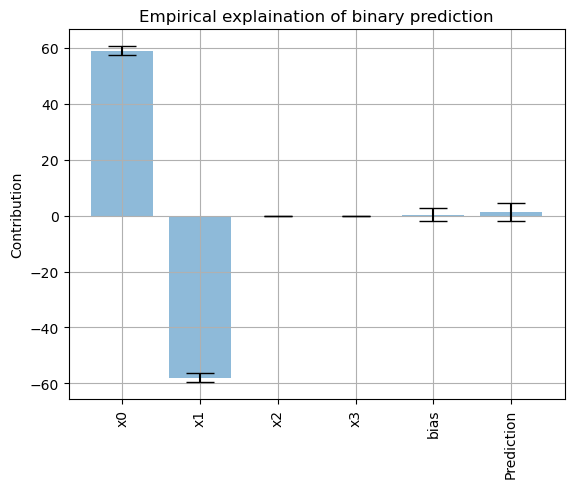

In [33]:
i = 12
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=False)

#### LIME explanation

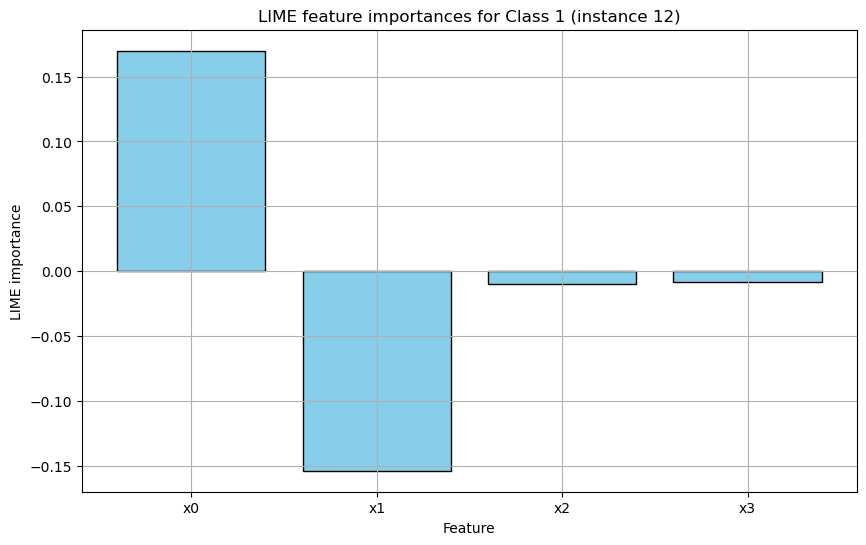

In [39]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

#### SHAP explanation

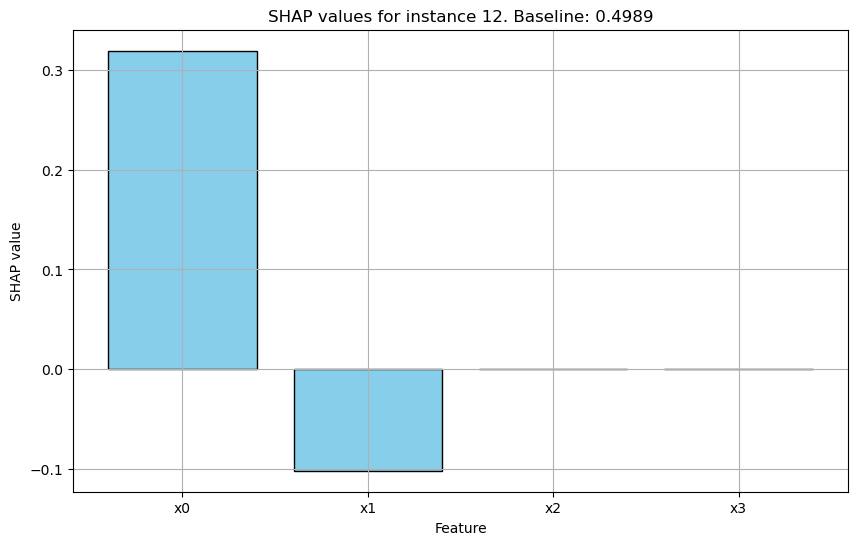

In [40]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [41]:
shap_vals.values

array([[ 0.31954778, -0.10211657,  0.        ,  0.        ]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


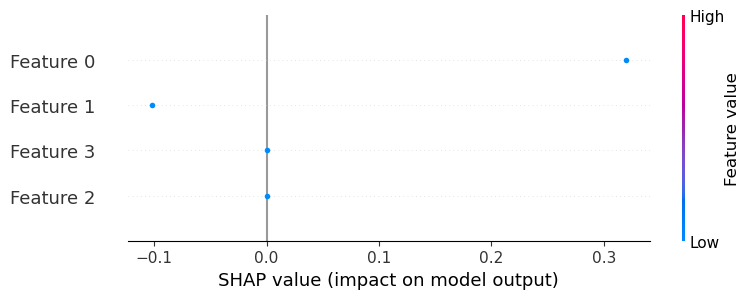

In [42]:
shap.summary_plot(shap_vals, X_test[i:i+1])

In [43]:
shap_vals

.values =
array([[ 0.31954778, -0.10211657,  0.        ,  0.        ]])

.base_values =
array([[0.49890224]])

.data =
array([[ 3.55481177, -3.50481279,  9.5701959 ,  3.81801819]])